# Delaunay Tesselation Field Estimator in 3D

In [1]:
#Load the numpy and scipy libraries
import numpy as np
from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union

@numba.jit(nopython=True, nogil=True)
def tetrahedron_volume(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]],
                                       points[sim[3]] - points[sim[0]])))) / 6

@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = tetrahedron_volume(sim, pts)
        for index in sim:
            rho[index] += vol
    return (3 + 1) * m / rho

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts: float64[:,:], simps: float64[:,:], rho: float64[:],
                      v: float64[:,:]) -> tuple[np.ndarray, np.ndarray]:
    N = len(simps)
    Drho = np.zeros((N, 3), dtype='float64')
    Dv   = np.zeros((N, 3, 3), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2, p3] = pts[s]
        [r0, r1, r2, r3] = rho[s]
        [v0, v1, v2, v3] = v[s]

        Ainv: float64[:,:] = np.linalg.inv(np.stack((p1 - p0, p2 - p0, p3 - p0)))
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0, r3 - r0])
        Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0, v3 - v0))
    return (Drho, Dv)

@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result

#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, velocities, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho, self.Dv = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho, self.velocities)

    #The interpolations
    def density(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])

    def v(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.velocities[pointIndex], self.Dv[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])
    
    def gradV(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        return self.Dv[simplexIndex]

    def theta(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        return (self.Dv[simplexIndex][...,0,0] + 
                self.Dv[simplexIndex][...,1,1] + 
                self.Dv[simplexIndex][...,2,2])

    def sigma(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        return np.array([[self.Dv[simplexIndex][...,0,0] - (self.Dv[simplexIndex][...,0,0] + 
                                                            self.Dv[simplexIndex][...,1,1] + 
                                                            self.Dv[simplexIndex][...,2,2]) / 3, 
                         (self.Dv[simplexIndex][...,0,1] + self.Dv[simplexIndex][...,1,0]) / 2,
                         (self.Dv[simplexIndex][...,0,2] + self.Dv[simplexIndex][...,2,0]) / 2],
                        [(self.Dv[simplexIndex][...,1,0] + self.Dv[simplexIndex][...,0,1]) / 2, 
                          self.Dv[simplexIndex][...,1,1] - (self.Dv[simplexIndex][...,0,0] + 
                                                            self.Dv[simplexIndex][...,1,1] + 
                                                            self.Dv[simplexIndex][...,2,2]) / 3,
                         (self.Dv[simplexIndex][...,1,2] + self.Dv[simplexIndex][...,2,1]) / 2],
                        [(self.Dv[simplexIndex][...,2,0] + self.Dv[simplexIndex][...,0,2]) / 2,
                         (self.Dv[simplexIndex][...,2,1] + self.Dv[simplexIndex][...,1,2]) / 2,
                          self.Dv[simplexIndex][...,2,2] - (self.Dv[simplexIndex][...,0,0] + 
                                                            self.Dv[simplexIndex][...,1,1] + 
                                                            self.Dv[simplexIndex][...,2,2]) / 3]]) 
    
    def omega(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        return (np.array([[np.zeros(len(simplexIndex)), 
                         (self.Dv[simplexIndex][...,0,1] - self.Dv[simplexIndex][...,1,0]) / 2,
                         (self.Dv[simplexIndex][...,0,2] - self.Dv[simplexIndex][...,2,0]) / 2],
                        [(self.Dv[simplexIndex][...,1,0] - self.Dv[simplexIndex][...,0,1]) / 2, 
                          np.zeros(len(simplexIndex)),
                         (self.Dv[simplexIndex][...,1,2] - self.Dv[simplexIndex][...,2,1]) / 2],
                        [(self.Dv[simplexIndex][...,2,0] - self.Dv[simplexIndex][...,0,2]) / 2,
                         (self.Dv[simplexIndex][...,2,1] - self.Dv[simplexIndex][...,1,2]) / 2,
                          np.zeros(len(simplexIndex))]])) 

Example

In [2]:
L = 128
points = np.load("example/points_3D.npy")
velocities = np.load("example/velocities_3D.npy")
m = np.ones(len(points))

In [3]:
%%time
dtfe = DTFE(points, velocities, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 3min 50s, sys: 4.95 s, total: 3min 54s
Wall time: 3min 55s


In [4]:
%%time
n = int(4 * L)
X, Y, Z = np.meshgrid(np.arange(0, L, L / n), np.arange(0, L, L / n), np.arange(0, L, L / n))

dens  = dtfe.density(X.flat, Y.flat, Z.flat).reshape((n,n,n))
vel   = dtfe.v(X.flat, Y.flat, Z.flat).reshape((n,n,n,3))
div   = dtfe.theta(X.flat, Y.flat, Z.flat).reshape((n,n,n))
shear = dtfe.sigma(X.flat, Y.flat, Z.flat).reshape((n,n,n,3,3))
curl  = dtfe.omega(X.flat, Y.flat, Z.flat).reshape((n,n,n,3,3))

CPU times: user 4min 21s, sys: 1min 30s, total: 5min 52s
Wall time: 3min 17s


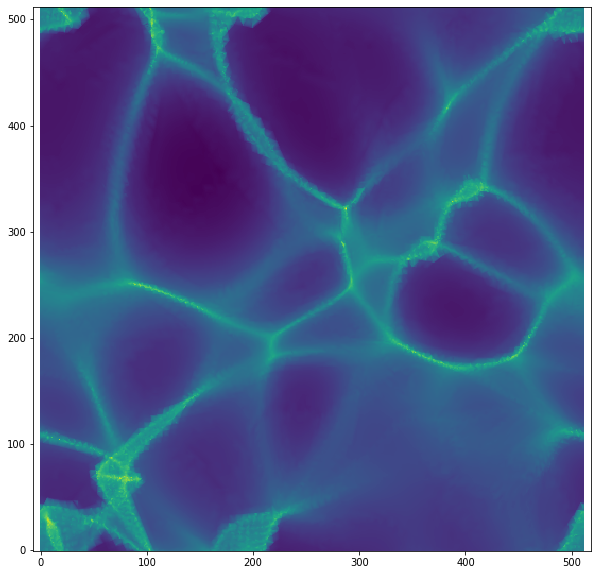

In [5]:
import matplotlib.pyplot as plt
def densPlot(data, imageSize):
    X = np.arange(0, data.shape[0])
    Y = np.arange(0, data.shape[1])
    X, Y = np.meshgrid(X, Y)

    plt.figure(figsize=(imageSize, imageSize))
    plt.pcolormesh(X, Y, data, shading='auto')
    plt.axis("equal")
    plt.show()

densPlot(np.log(dens[0]), 10)